# Visualization of in low dimentional distribution
本ページでは、nucleotidoのシークエンスをembedする方法を検討する。  
それにあたって、nucleotidoをシークエンスごとに切り出した上で、  
それを一つのトークンと考えてラベルエンコーディング  
さらに、それを使ってPCAやt-SNEなどの可視化を行い、分類方法を検討する。

## Summary
- PCA
- PSL
などの手法で2次元にマッピングしたが、ラベルの異なる遺伝子が重なっており、分離しきれていないことがわかった。  
これらの手法を用いる場合は、それなりに高次元の空間にマッピングする必要があるのではないかと思われる。  

- t-SNE
- UMAP
については PCAよりはよく分離できていることがわかる。  
特にt-SNEについては、そのことがよくわかる  

小さくしすぎない範囲で低次元にマッピングし  
非線形の分類手法を使えば、  
ある程度の精度で分類できるのではないかと考えた。  

In [24]:
import numpy as np
# import editdistance
import pandas as pd

import matplotlib.pyplot as plt
# import umap

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [4]:
MAX_SEQ = 30000
K = 16
N = 16000

In [5]:
strain2num = {'B.1.1.7': 0, 'B.1.427': 1, 'B.1.526': 2, 'P.1': 3}

In [6]:
acid2num = {'A': 1, 'C': 2, 'G':3, 'T':4, 'N':0}

# シークエンスごとに取り出す
シークエンス長さKを使って、Kごとに切り出す。  

In [8]:
with open("dataset/Challenge.fa", "r") as f:
    a = f.readlines()
    labels = []
    eds = []

#     print("edit distance between idx 1 and 2500:", 
#           editdistance.eval(a[1], a[5001]))

    for i in range(int(N/2)):
        labels.append(strain2num[a[i*2][1:].split("_")[0]])

    unique_seq = set()
    sequences = []
    for i in range(int(N/2)):
        seq = list(map(lambda x : "".join(x), 
                       np.append(np.array(list(a[i*2+1])), 
                                ["O" for i in range(MAX_SEQ - len(a[i*2+1]))])
                       .reshape(8, -1)
                       .transpose()
                       .tolist()))
        sequences.append(seq)
        unique_seq |= set(seq)

編集距離は約30,000の長さのうち429ということで約1%の差になっている。

In [9]:
del a

# Encode indices
ラベルエンコーディングでエンコードする

In [ ]:
enc = LabelEncoder()
enc.fit(list(unique_seq))
ids = enc.transform(np.array(sequences).reshape(-1)).reshape(len(sequences), -1)

In [12]:
ids.shape

(8000, 3750)

# Visualization
ここでは
- PCA
- PSL
- UMAP
- t-SNE

での可視化を行う

## PCA

In [63]:
pca = PCA(n_components=200)
pca.fit(ids)
trf = pca.transform(ids)

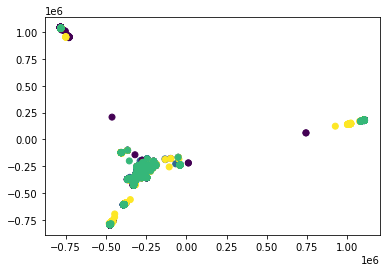

In [18]:
plt.scatter(trf[:, 0], trf[:, 1], c=labels[:len(trf)])

## PLS

In [64]:
pls2 = PLSRegression(n_components=200)
pls2.fit(ids, labels[:len(ids)])
trf2 = pls2.transform(ids)

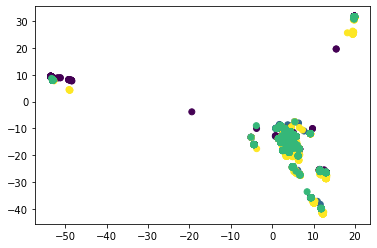

In [20]:
plt.scatter(trf2[:, 0], trf2[:, 1], c=labels[:len(trf2)])

## UMAP

/Users/yamaguchir/miniconda3/envs/idash/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


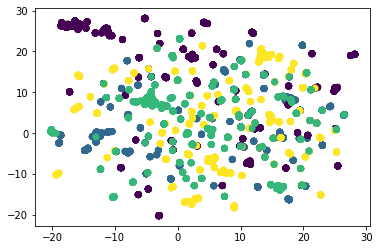

In [15]:
mapper = umap.UMAP(random_state=0)
embedding = mapper.fit_transform(ids)
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels[:len(embedding)])

## TSNE

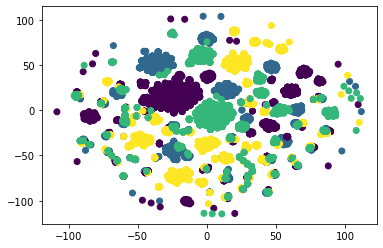

In [16]:
from sklearn.manifold import TSNE
embedding2 = TSNE(n_components=2).fit_transform(ids)
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=labels[:len(embedding2)], )

In [14]:
from sklearn.model_selection import train_test_split

In [79]:
f = np.abs(np.fft.fft(ids)) ** 2
X = ids.reshape(-1, f.shape[1]) # np.append(trf, trf2, axis=1)
# X = (X - X.mean()) / X.std()

enc = OneHotEncoder()

Y = np.array(labels).reshape(-1,1)

Y = enc.fit_transform(Y)
Y = np.array(Y.toarray(), dtype="int32")

In [80]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [83]:
pca = PCA(n_components=100)
pls = PLSRegression(n_components=100)
pca.fit(x_train)
pls.fit(x_train, y_train)
x_train = np.append(pca.transform(x_train), pls.transform(x_train), axis=1)
x_test = np.append(pca.transform(x_test), pls.transform(x_test), axis=1)

In [85]:
mean, std = x_train.mean(), x_train.std()
standardize = lambda x: (x - mean) / std

x_train = standardize(x_train)
x_test = standardize(x_test)

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D, Conv2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [87]:
x_train = x_train.reshape(-1, 200, 1)
x_test = x_test.reshape(-1, 200, 1)

In [3]:
# Refarences:
# Highly Accurate CNN Inference Using Approximate Activation Functions over Homomorphic Encryption
# Takumi Ishiyama, Takuya Suzuki, Hayato Yamana, Waseda Univ.
# https://arxiv.org/pdf/2009.03727.pdf


class ApproximatedSwish(tf.keras.layers.Layer):
    def __init__(self, degree=2, ranges=4, **kwargs):
        super(ApproximatedSwish, self).__init__(**kwargs)
        if degree == 2:
            if ranges == 4:
                self._func = lambda x: 0.12592 + 0.5*x + 0.145276*(x**2)
            elif ranges == 6:
                self._func = lambda x: 0.0851505 + 0.5*x + 0.344125*(x**2)
            else:
                raise ValueError(f"Approximated swish range is 4 or 6. not {ranges}")
        elif degree == 4:
            if ranges == 4:
                self._func = lambda x: 0.03347 + 0.5*x + 0.19566*(x**2) - 0.005075*(x**4)
            elif ranges == 6:
                self._func = lambda x: 0.1198 + 0.5*x + 0.1473*(x**2) - 0.002012*(x**4)
            else:
                raise ValueError(f"Approximated swish range is 4 or 6. not {ranges}")

    def call(self, x):
        return self._func(x)

NameError: name 'tf' is not defined

In [94]:
model = Sequential([
    Conv1D(16, 11, input_shape=(x_train.shape[1], x_train.shape[2]), strides=2),
    ApproximatedSwish(degree=2, ranges=4)
    Conv1D(32, 15, strides=2),
    ApproximatedSwish(degree=2, ranges=4)
    Conv1D(64, 21, strides=2),
    ApproximatedSwish(degree=2, ranges=4)
    GlobalAveragePooling1D(),
    Dense(4),
    Activation('softmax'),
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [96]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_test, y_test),
)

Epoch 1/30
225/225 [==============================] - 1s 6ms/step - loss: 0.2134 - accuracy: 0.9214 - val_loss: 0.3550 - val_accuracy: 0.9162
Epoch 2/30
225/225 [==============================] - 1s 6ms/step - loss: 0.2115 - accuracy: 0.9258 - val_loss: 0.3106 - val_accuracy: 0.9212
Epoch 3/30
225/225 [==============================] - 1s 6ms/step - loss: 0.1981 - accuracy: 0.9315 - val_loss: 0.3144 - val_accuracy: 0.9187
Epoch 4/30
225/225 [==============================] - 1s 6ms/step - loss: 0.1912 - accuracy: 0.9332 - val_loss: 0.3173 - val_accuracy: 0.9262
Epoch 5/30
225/225 [==============================] - 1s 6ms/step - loss: 0.1825 - accuracy: 0.9333 - val_loss: 0.3000 - val_accuracy: 0.9375
Epoch 6/30
225/225 [==============================] - 1s 6ms/step - loss: 0.1835 - accuracy: 0.9353 - val_loss: 0.3196 - val_accuracy: 0.9312
Epoch 7/30
225/225 [==============================] - 1s 6ms/step - loss: 0.1790 - accuracy: 0.9356 - val_loss: 0.3080 - val_accuracy: 0.9375
Epoch 

In [98]:
x_test.shape

(800, 200, 1)

In [ ]:
model.predict(x_test[0])

In [55]:
from sklearn.neural_network import MLPClassifier

lf = MLPClassifier(alpha=1e-7, activation='tanh',
                   hidden_layer_sizes=(1024), random_state=1, max_iter=100)
lf.fit(x_train, y_train)

MLPClassifier(activation='tanh', alpha=1e-07, hidden_layer_sizes=1024,
              max_iter=100, random_state=1)

In [48]:
from sklearn.metrics import accuracy_score

In [56]:
pred = lf.predict(x_test)
accuracy_score(pred, y_test)

0.54

In [86]:
pred

array([2, 0, 2, 0, 0, 3, 1, 1, 1, 0, 3, 2, 3, 3, 1, 1, 2, 2, 0, 2, 2, 3,
       3, 3, 3, 1, 0, 1, 1, 3, 0, 1, 0, 2, 0, 2, 1, 3, 2, 1, 1, 0, 1, 3,
       2, 2, 1, 3, 3, 1, 3, 0, 2, 3, 0, 1, 1, 0, 0, 2, 3, 0, 2, 0, 1, 1,
       3, 1, 3, 0, 2, 3, 1, 0, 3, 3, 3, 1, 0, 0, 1, 3, 1, 0, 1, 2, 3, 1,
       3, 3, 2, 1, 0, 3, 1, 1, 1, 3, 0, 1, 1, 0, 1, 0, 2, 0, 2, 0, 2, 2,
       0, 1, 1, 1, 1, 2, 1, 2, 1, 0, 0, 1, 1, 1, 1, 3, 1, 3, 2, 1, 3, 3,
       2, 3, 0, 3, 3, 1, 2, 2, 1, 1, 0, 3, 3, 2, 1, 1, 2, 3, 3, 1, 1, 2,
       0, 3, 0, 0, 0, 3, 0, 0, 1, 0, 0, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 3,
       3, 3, 1, 1, 3, 0, 1, 1, 2, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 0, 1, 1,
       0, 0, 1, 3, 0, 1, 0, 1, 3, 0, 2, 2, 0, 0, 0, 3, 0, 2, 2, 2, 2, 0,
       2, 0, 1, 2, 1, 2, 3, 2, 2, 1, 1, 3, 2, 3, 3, 1, 1, 1, 1, 1, 0, 0,
       3, 3, 3, 3, 0, 0, 1, 1, 1, 1, 3, 1, 3, 1, 1, 0, 0, 2, 3, 0, 2, 3,
       0, 1, 0, 3, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 3, 3, 3, 2, 0, 1, 1,
       0, 0, 1, 0, 2, 1, 3, 1, 2, 3, 1, 0, 1, 1, 1,

In [78]:
f = standardize(f)